In [100]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flight-price-prediction/business.csv
/kaggle/input/flight-price-prediction/economy.csv
/kaggle/input/flight-price-prediction/Clean_Dataset.csv


In [101]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context='talk', style='darkgrid', font='MS GOTHIC')

In [102]:
# df = pd.read_csv('/kaggle/input/flight-price-prediction/Clean_Dataset.csv')
# Unnamedが出てしまうので、index_col=0にする。→Unnamedがindexになる。
df = pd.read_csv('/kaggle/input/flight-price-prediction/Clean_Dataset.csv', index_col=0)
df.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [103]:
df.info() # 目的変数がprice

<class 'pandas.core.frame.DataFrame'>
Index: 300153 entries, 0 to 300152
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           300153 non-null  object 
 1   flight            300153 non-null  object 
 2   source_city       300153 non-null  object 
 3   departure_time    300153 non-null  object 
 4   stops             300153 non-null  object 
 5   arrival_time      300153 non-null  object 
 6   destination_city  300153 non-null  object 
 7   class             300153 non-null  object 
 8   duration          300153 non-null  float64
 9   days_left         300153 non-null  int64  
 10  price             300153 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 27.5+ MB


In [104]:
# 特徴量を2種類に分けるためにまずはカラムを表示
df.columns # どんな種類のデータがあるかわかる

Index(['airline', 'flight', 'source_city', 'departure_time', 'stops',
       'arrival_time', 'destination_city', 'class', 'duration', 'days_left',
       'price'],
      dtype='object')

In [105]:
# カテゴリカル(文字列)とニューメリック(数字)に分ける
cat_features = ['airline', 'flight', 'source_city', 'departure_time', 'stops',
       'arrival_time', 'destination_city', 'class'] # classまで
num_features = ['duration', 'days_left'] # durationから

In [106]:
# 何種類持っているか確認(ユニーク値の取得)

In [107]:
for feature in cat_features:
    print(f'{feature} : {df[feature].nunique()}') # dfのfeatureのカラムのnunique(何種類か)を確認
    print(df[feature].unique()) # そのユニーク値を(実際のユニークな値)確認
    print('='*20)

airline : 6
['SpiceJet' 'AirAsia' 'Vistara' 'GO_FIRST' 'Indigo' 'Air_India']
flight : 1561
['SG-8709' 'SG-8157' 'I5-764' ... '6E-7127' '6E-7259' 'AI-433']
source_city : 6
['Delhi' 'Mumbai' 'Bangalore' 'Kolkata' 'Hyderabad' 'Chennai']
departure_time : 6
['Evening' 'Early_Morning' 'Morning' 'Afternoon' 'Night' 'Late_Night']
stops : 3
['zero' 'one' 'two_or_more']
arrival_time : 6
['Night' 'Morning' 'Early_Morning' 'Afternoon' 'Evening' 'Late_Night']
destination_city : 6
['Mumbai' 'Bangalore' 'Kolkata' 'Hyderabad' 'Chennai' 'Delhi']
class : 2
['Economy' 'Business']


**気付き**
- source_cityとdestination_cityが同じ6つの区分
- departure_timeとarrival_timeが同じ6つの区分
- AirlineとFlightの先頭に文字は何らかの関係がありそう → 次にもう少しこの中身を見てみる 

In [108]:
# Vistara: UK
# Indigo: 6E
# Air_India: AI
# のように種類ごとに同じになっている
df[['airline', 'flight']].sample(10)

,airline,flight
288802,Vistara,UK-826
177382,Air_India,AI-543
143006,Air_India,AI-9720
53648,GO_FIRST,G8-365
162276,Air_India,AI-515
293021,Air_India,AI-440
49341,Air_India,AI-671
174055,Vistara,UK-898
239262,Vistara,UK-970
146910,Indigo,6E-6214


**新しく特徴量を作成する**
- Flightナンバーを先頭に文字と残りの数字で分けてみる

In [109]:
# strで文字列にして、'-'で分割する
# expandで分割の前後を別のカラムにする
df[['flight_code', 'flight_number']] = df['flight'].str.split('-', expand=True)

# 動作確認
# df['flight'].str.split('-', expand=True)

In [110]:
df.head() # データセットの末尾に'flight_code', 'flight_number'が追加されていることを確認

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price,flight_code,flight_number
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953,SG,8709
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953,SG,8157
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956,I5,764
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955,UK,995
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955,UK,963


In [111]:
# 新しく作成した特徴量を特徴量リストに格納
cat_features = cat_features + ['flight_code', 'flight_number']

In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300153 entries, 0 to 300152
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           300153 non-null  object 
 1   flight            300153 non-null  object 
 2   source_city       300153 non-null  object 
 3   departure_time    300153 non-null  object 
 4   stops             300153 non-null  object 
 5   arrival_time      300153 non-null  object 
 6   destination_city  300153 non-null  object 
 7   class             300153 non-null  object 
 8   duration          300153 non-null  float64
 9   days_left         300153 non-null  int64  
 10  price             300153 non-null  int64  
 11  flight_code       300153 non-null  object 
 12  flight_number     300153 non-null  object 
dtypes: float64(1), int64(2), object(10)
memory usage: 32.1+ MB


In [113]:
# flight_numberは数字なので、int型にする
df['flight_number'] = df['flight_number'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300153 entries, 0 to 300152
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           300153 non-null  object 
 1   flight            300153 non-null  object 
 2   source_city       300153 non-null  object 
 3   departure_time    300153 non-null  object 
 4   stops             300153 non-null  object 
 5   arrival_time      300153 non-null  object 
 6   destination_city  300153 non-null  object 
 7   class             300153 non-null  object 
 8   duration          300153 non-null  float64
 9   days_left         300153 non-null  int64  
 10  price             300153 non-null  int64  
 11  flight_code       300153 non-null  object 
 12  flight_number     300153 non-null  int64  
dtypes: float64(1), int64(3), object(9)
memory usage: 32.1+ MB


In [114]:
# flight_codeのユニーク値を確認
# 予想が正しければ、airlineと同じ6個になるはず
df['flight_code'].unique()

array(['SG', 'I5', 'UK', 'G8', '6E', 'AI'], dtype=object)

In [115]:
# airlineと等しくなるか確認
df[['airline', 'flight_code']].value_counts() # 二つのカラムの中身と何個あるかを表示

# 動作確認
# df[['airline', 'flight_code']] # 指定した二つのカラムの中身を表示
# df['flight_code'].value_counts() # 指定したカラムの中身と何個あるか表示

airline    flight_code
Vistara    UK             127859
Air_India  AI              80892
Indigo     6E              43120
GO_FIRST   G8              23173
AirAsia    I5              16098
SpiceJet   SG               9011
Name: count, dtype: int64

**Next Action**
- flight_numberとチケットの価格に何らかの関係があるかを確認

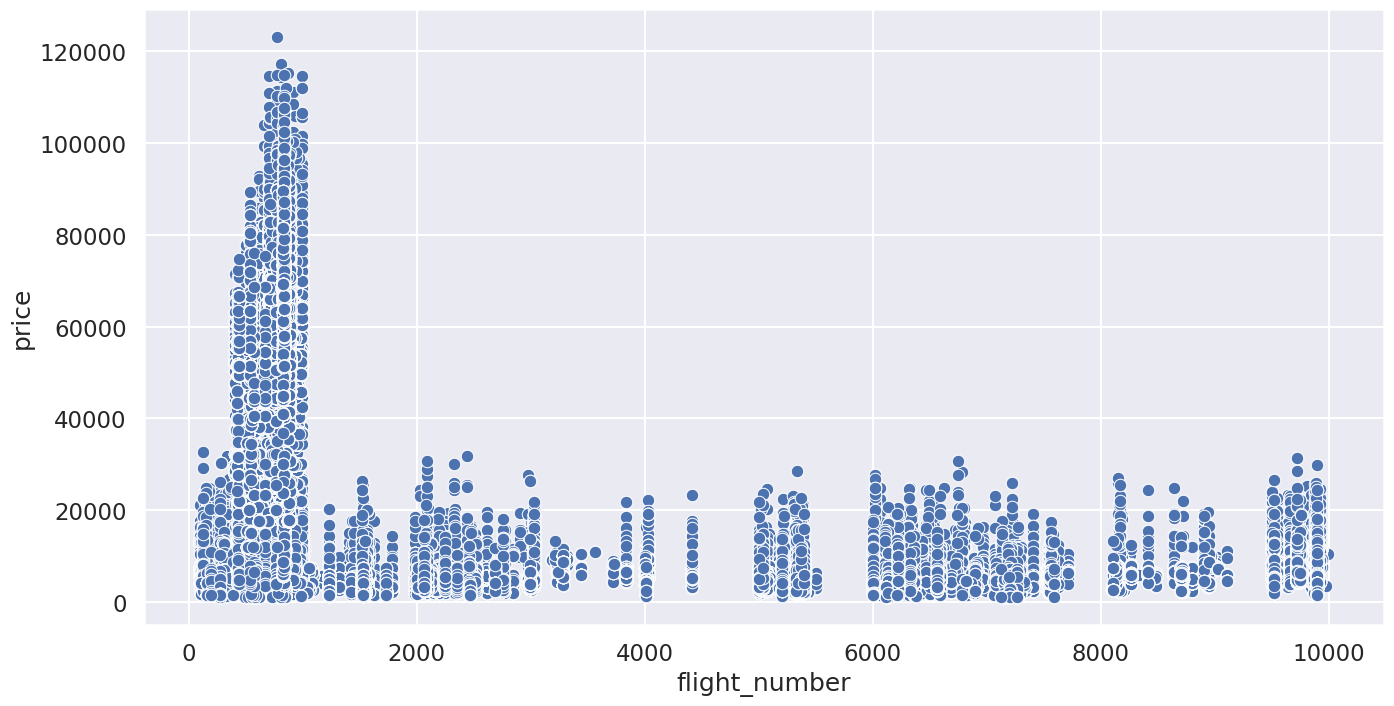

In [116]:
plt.figure(figsize=(16, 8))
sns.scatterplot(data=df, x='flight_number', y='price')
plt.show()

**気付き**
- flight_numberが3桁か4桁で価格が異なる→1000未満のものを再度確認

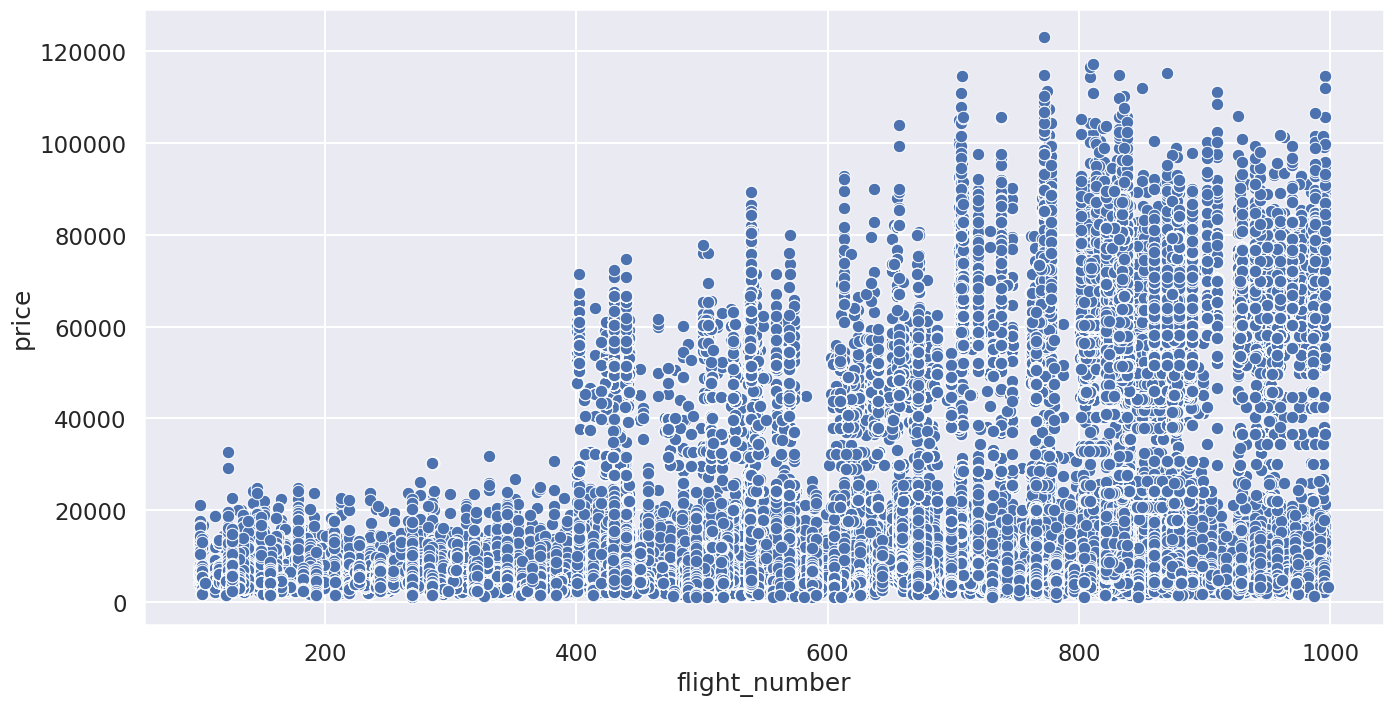

In [117]:
# 1000未満のデータを確認
plt.figure(figsize=(16, 8))
sns.scatterplot(data=df[df['flight_number'] < 1000], x='flight_number', y='price')
plt.show()

**気付き**
- **右肩上がりの傾向が見られる**

**Next Action**
- しかし、airlineごとに異なる可能性もあるため、**airline別にflight_numberを確認**

In [118]:
airlines = df['airline'].unique() # 最初にairline一覧を取得

In [119]:
# # 動作確認
# airline = 'Vistara'
# df[df['airline'] == airline] # airline=Vistaraのrowを表示
  # メモ：
  # df['airline'] == airline で 列(columns=縦)方向に [True, true, False, ...]のようなリストが作成される
  # そのリストをもとに、Trueの行をdfから取得するイメージ

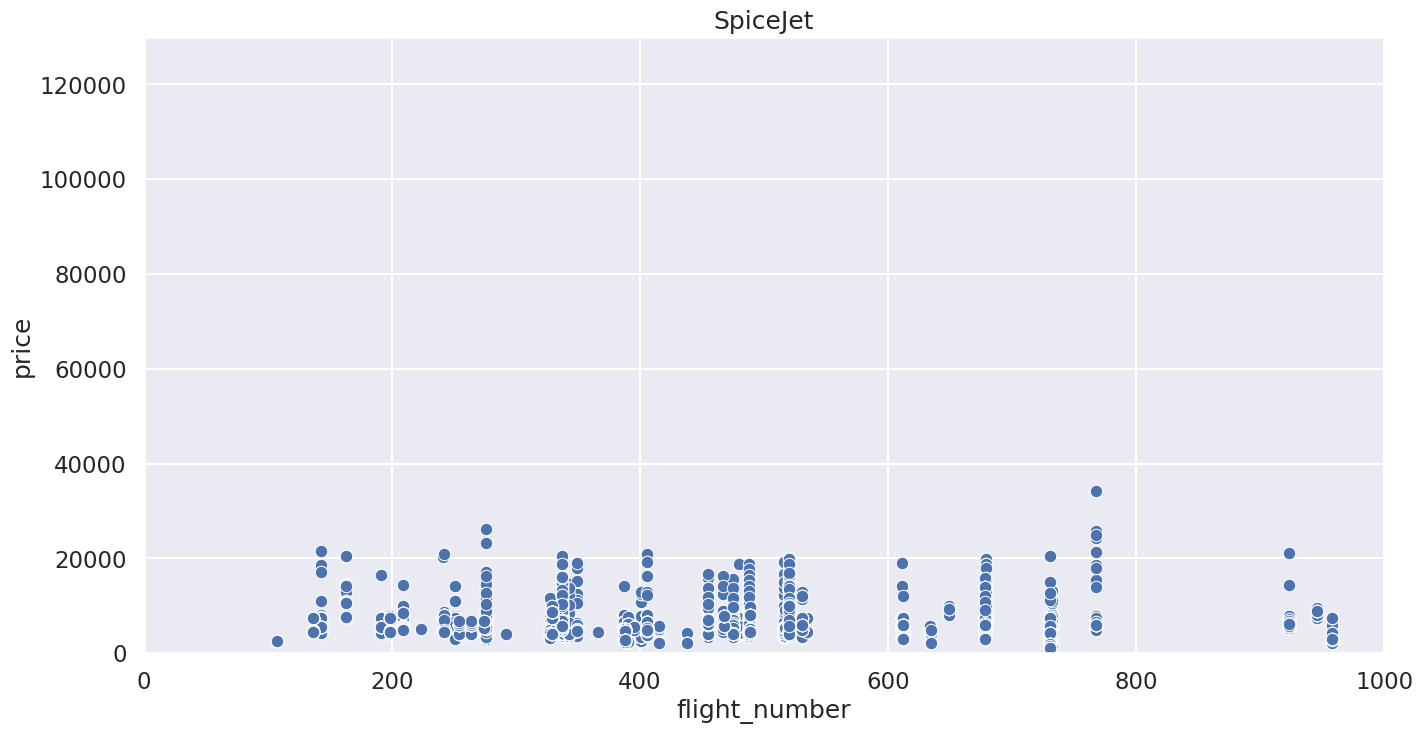

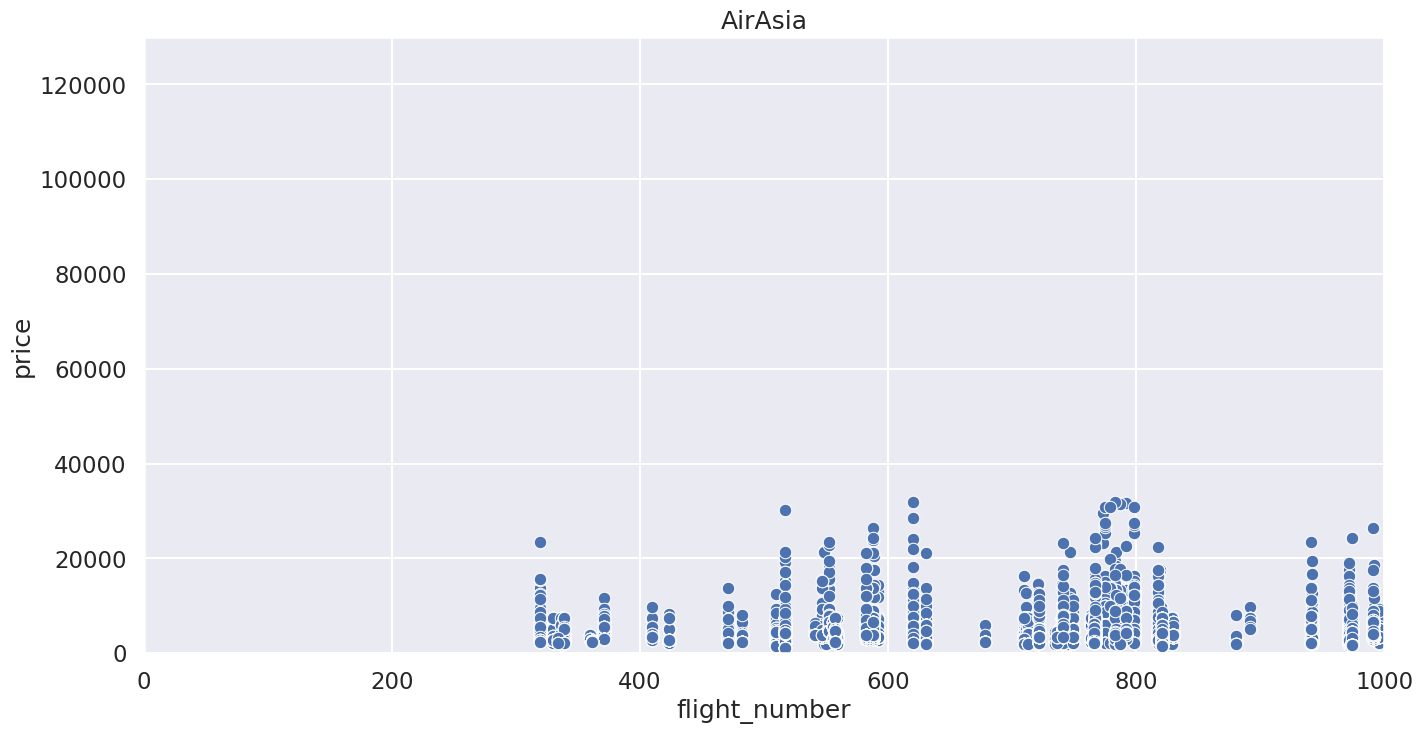

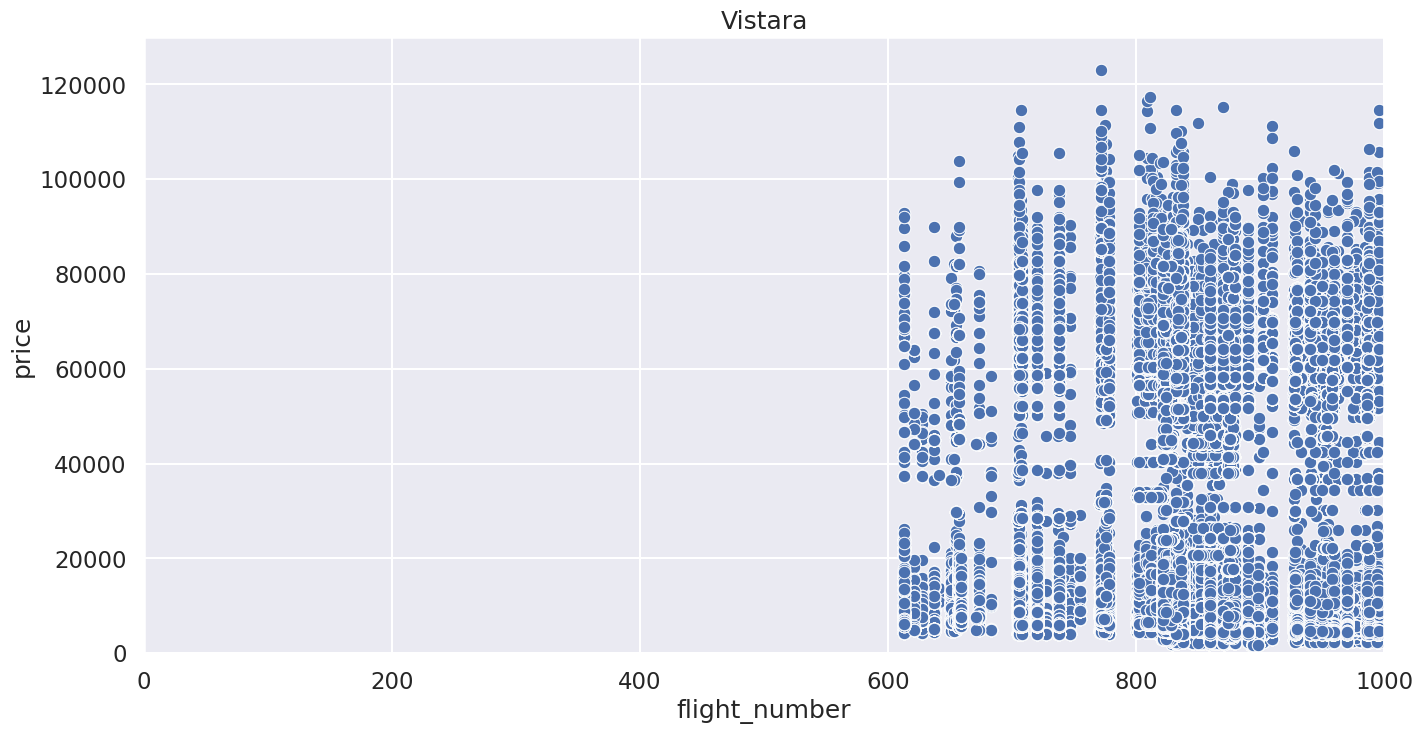

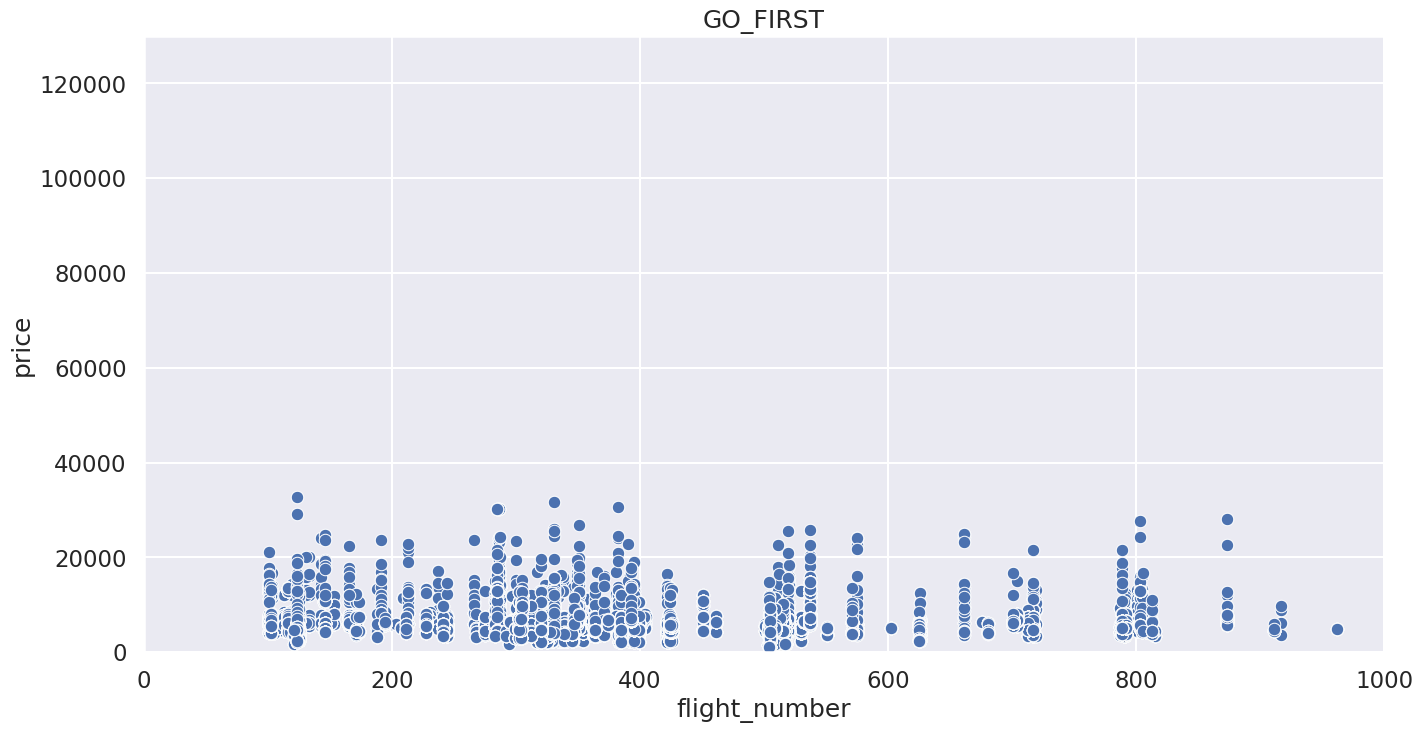

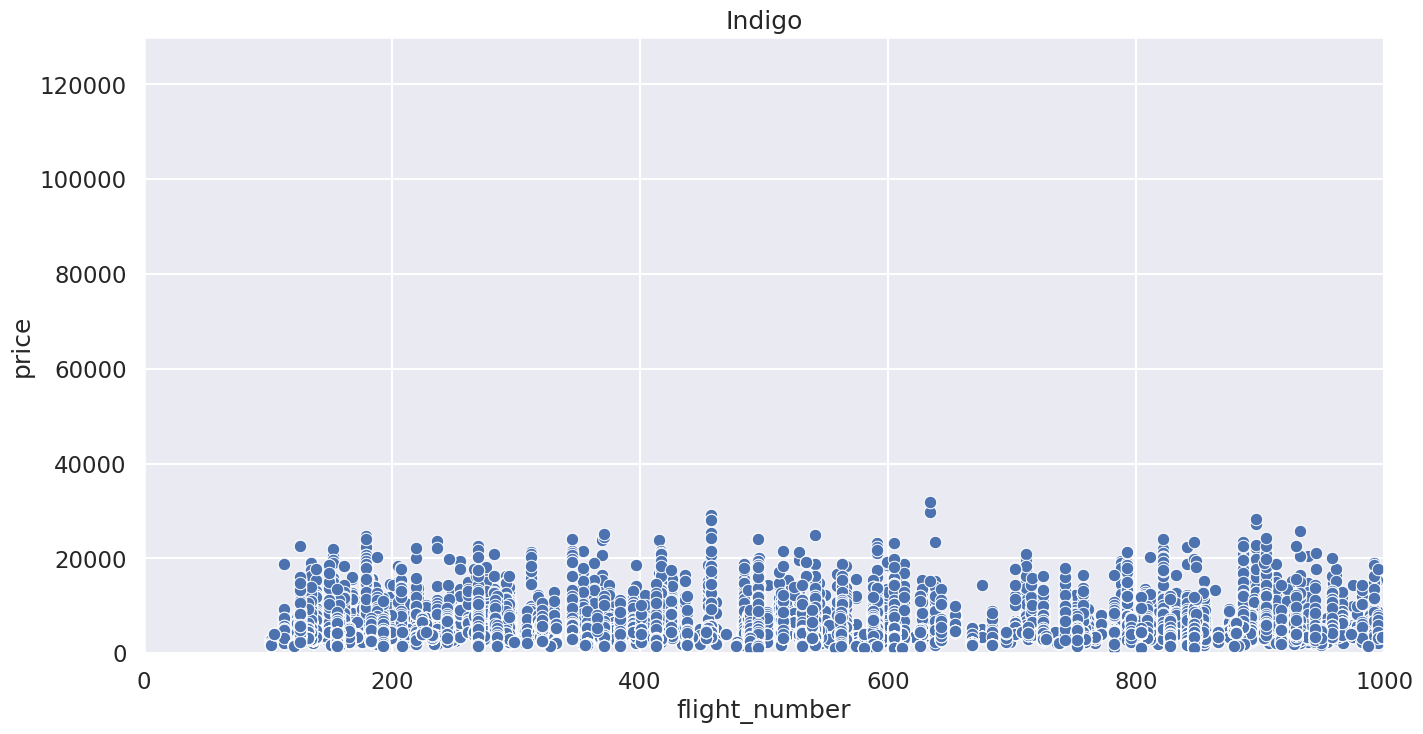

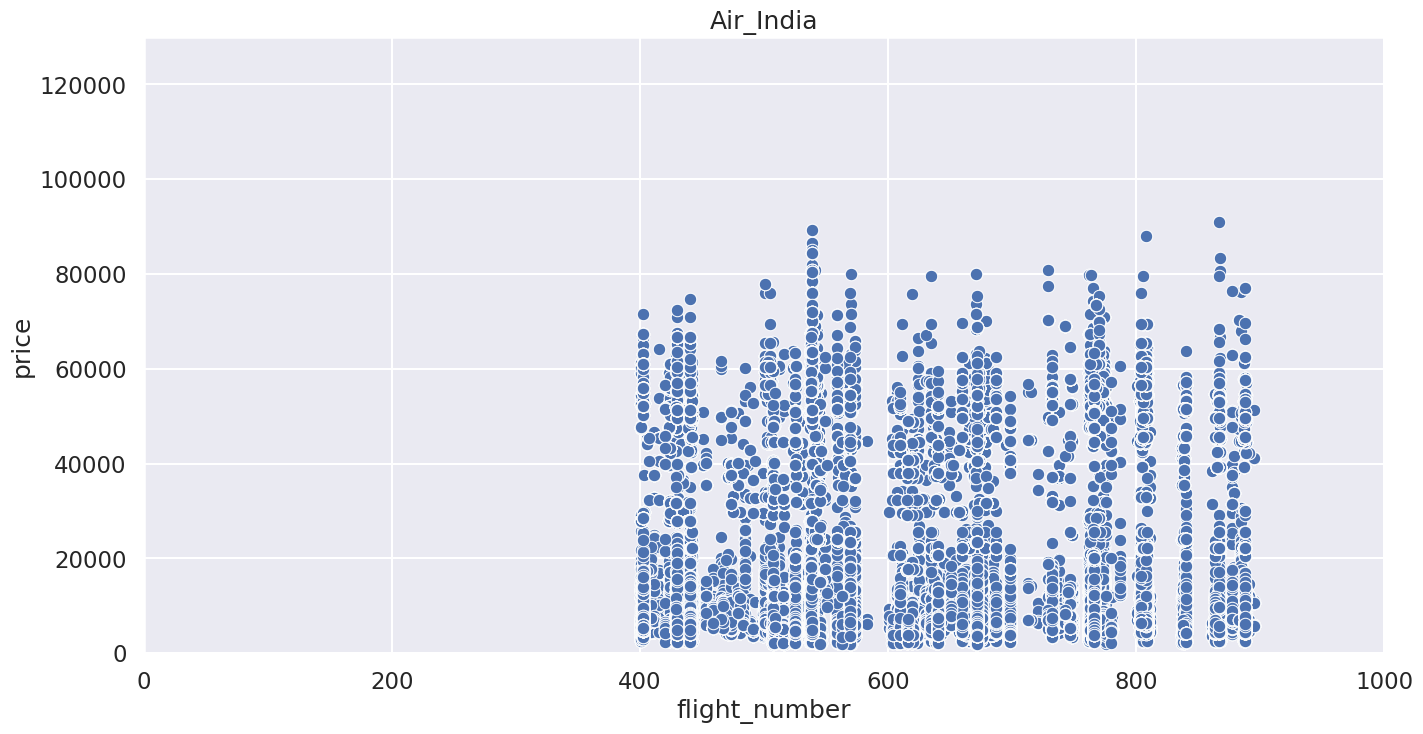

In [120]:
# airline別にflight_numberを確認
for airline in airlines: # airlineの種類ごとに分割
    # あるairlineのdata(row)を取得し、flight_numberを抽出
    df_temp = df[df['airline'] == airline] # 一時的なdf_tempを作成し、airlineに該当するrowのみ抽出
    plt.figure(figsize=(16, 8))
    sns.scatterplot(data=df_temp[df_temp['flight_number'] < 1000], x='flight_number', y='price')
    plt.title(airline)
    plt.xlim(0, 1000) # スケールが異なっているので、一定にする
    plt.ylim(0, 130000) # スケールが異なっているので、一定にする
    plt.show()

**気付き**
- flight_number(1000未満)とpriceの相関はそんなになさそう

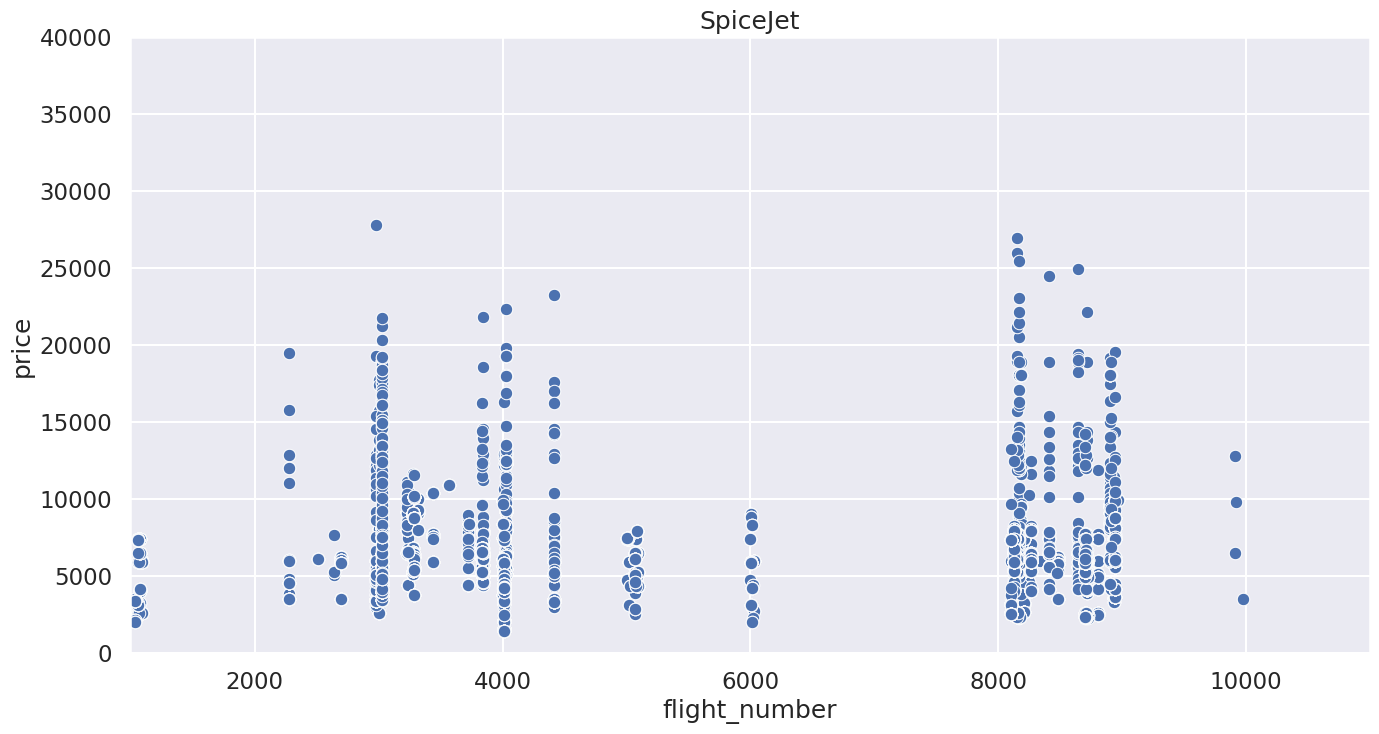

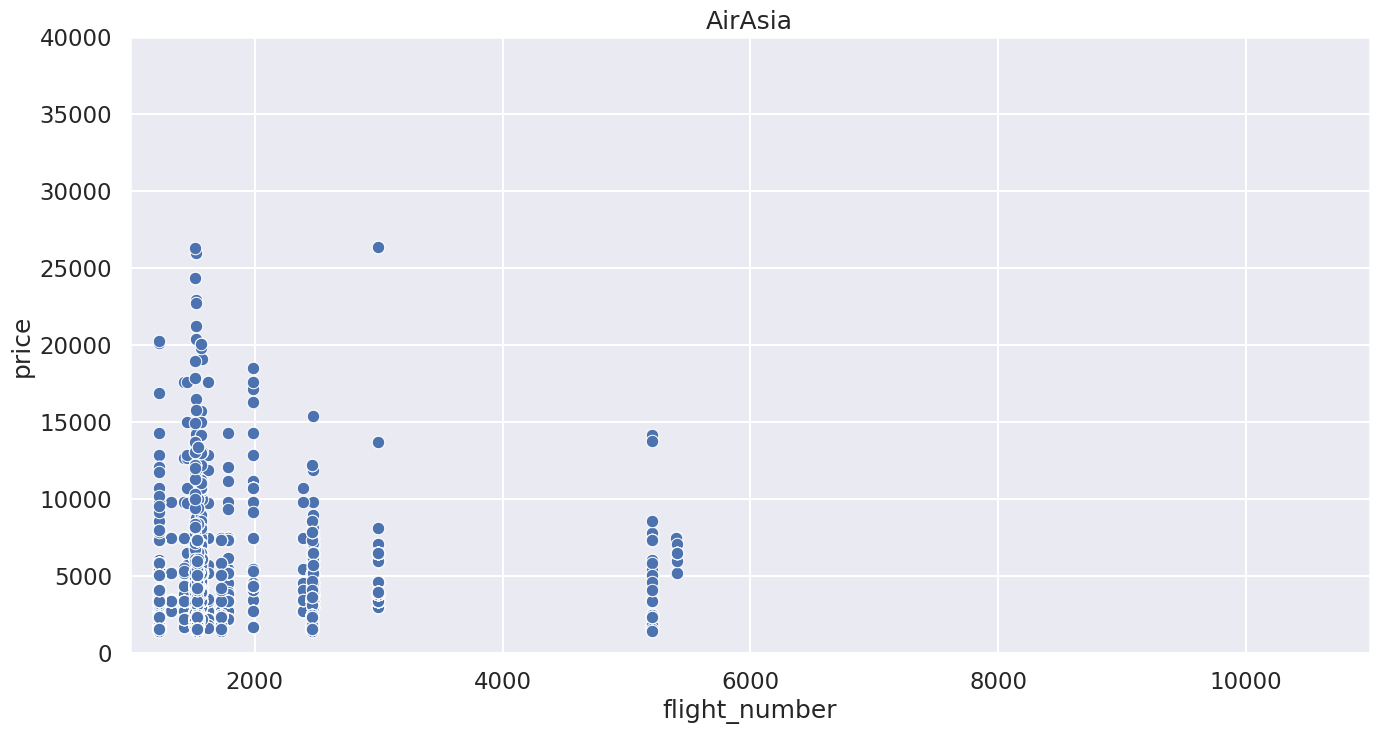

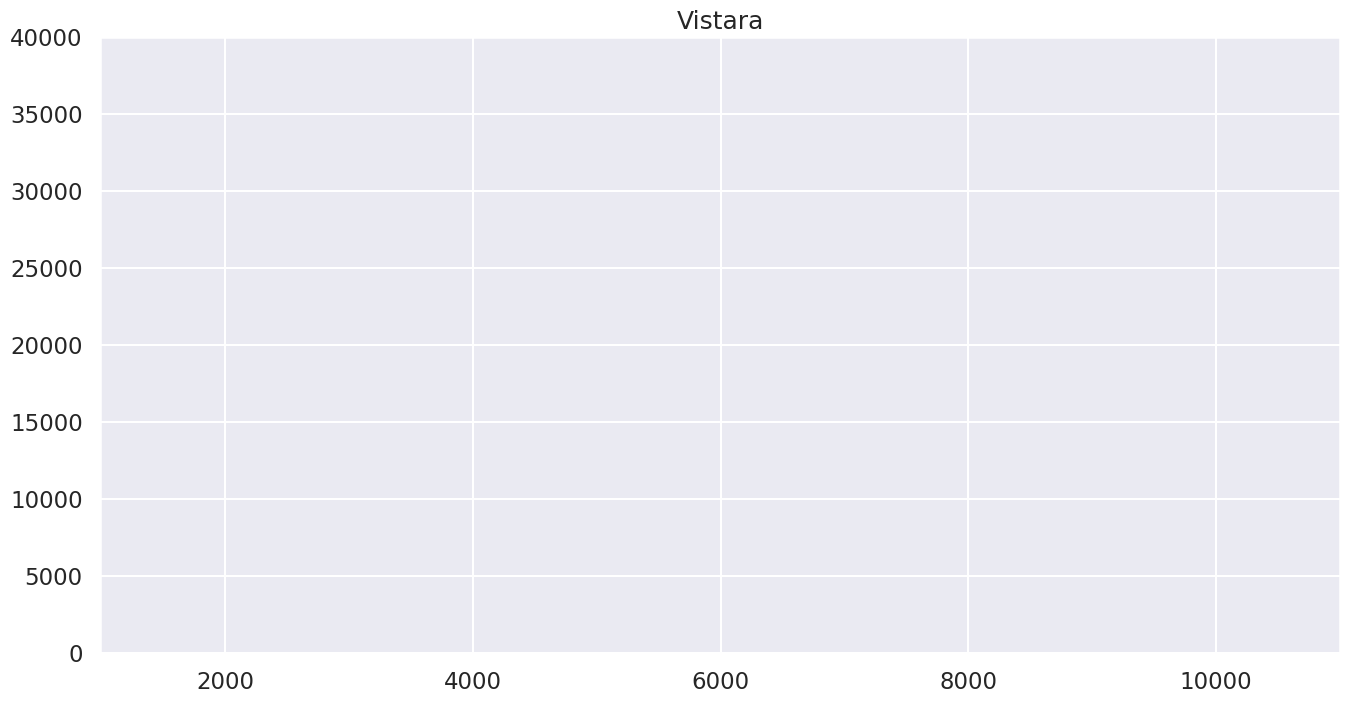

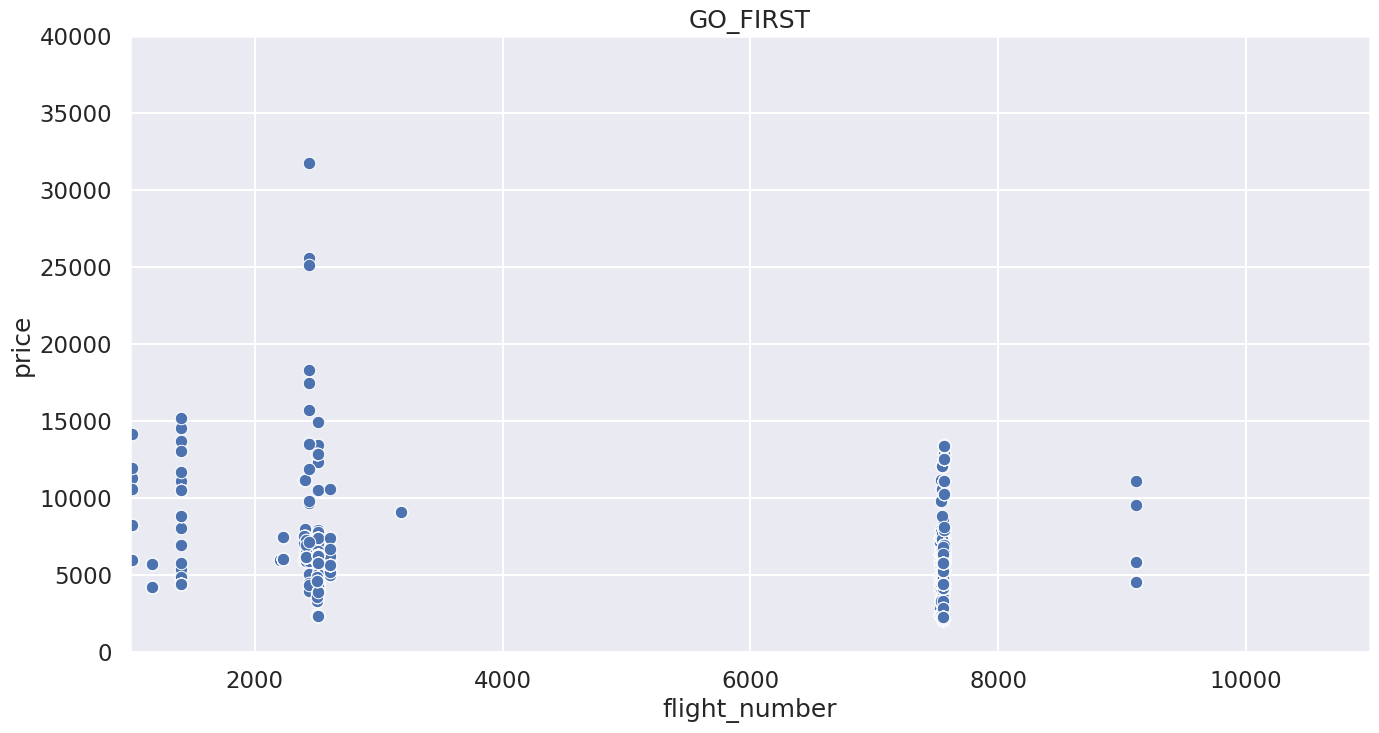

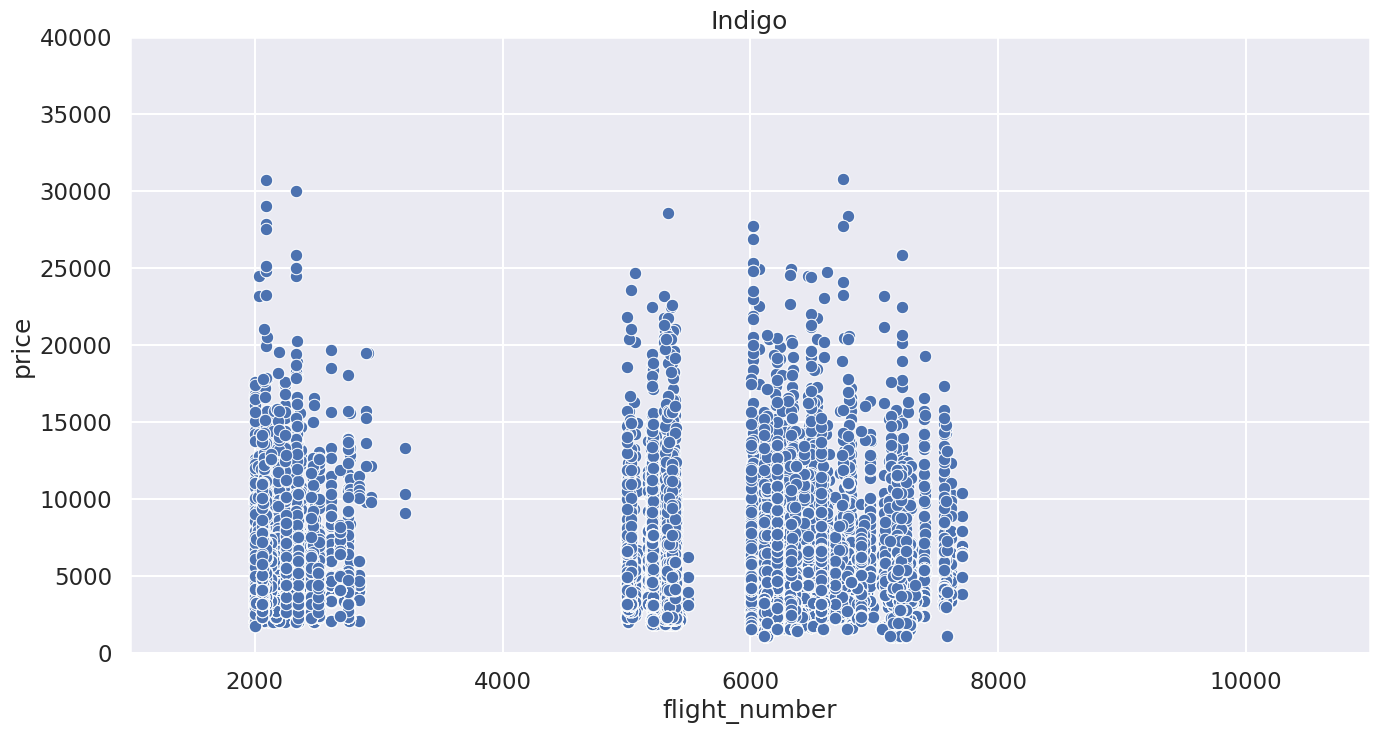

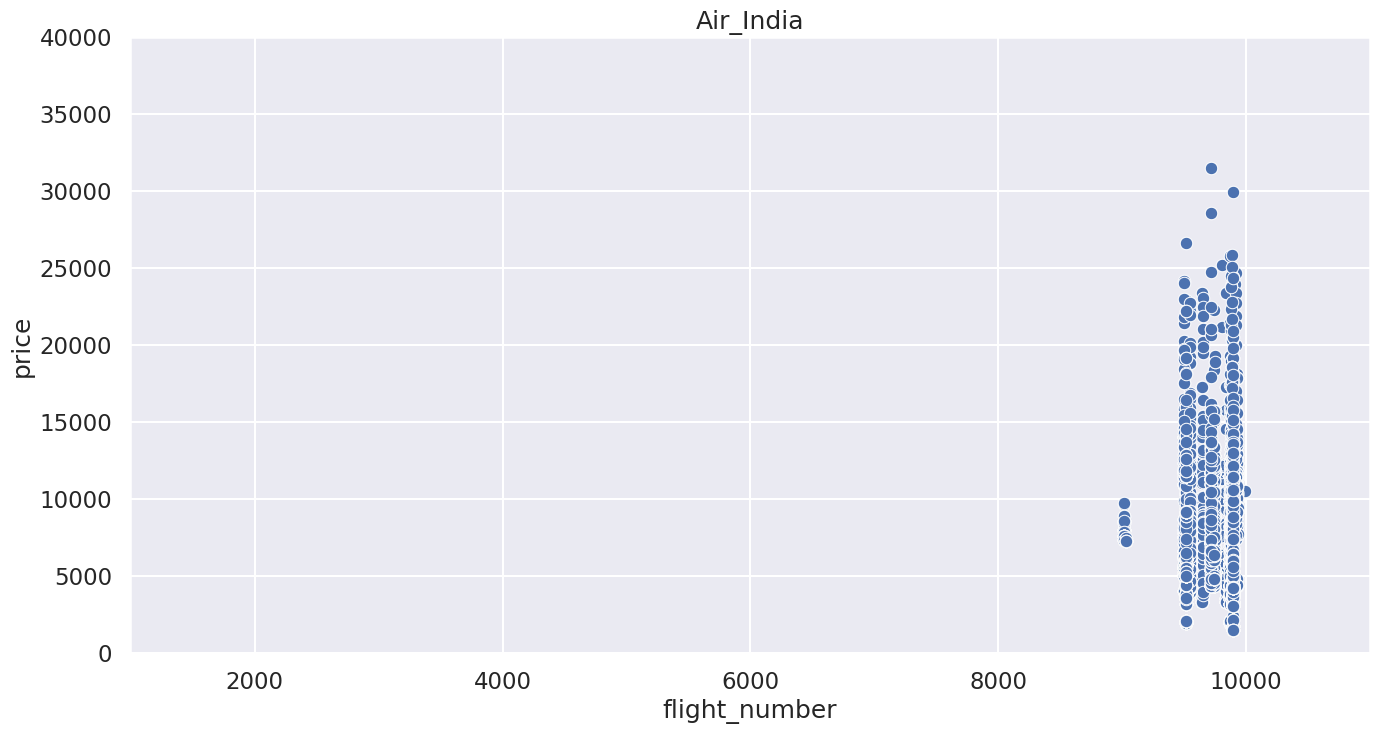

In [121]:
# fligh_number >= 1000も一応確認

# airline別にflight_numberを確認
for airline in airlines: # airlineの種類ごとに分割
    # あるairlineのdata(row)を取得し、flight_numberを抽出
    df_temp = df[df['airline'] == airline] # 一時的なdf_tempを作成し、airlineに該当するrowのみ抽出
    plt.figure(figsize=(16, 8))
    sns.scatterplot(data=df_temp[df_temp['flight_number'] >= 1000], x='flight_number', y='price')
    plt.title(airline)
    plt.xlim(990, 11000) # スケールが異なっているので、一定にする
    plt.ylim(0, 40000) # スケールが異なっているので、一定にする
    plt.show()

**気付き**
- 1000以上もあまりそう関係がありそうには見えないので、一旦新しい特徴量の作成は行わなず、先に進む


**Next Action**
- **重複するカラムを削除する**

In [122]:
# flight_codeとflight_numberに分けたflightは削除
# flight_codeもairlineと1:1で対応するので削除
# flight_numberも今回は考慮しない(先ほど相関関係があまりなかったので)

df.drop(columns=['flight', 'flight_code', 'flight_number'], inplace=True)

In [123]:
# 特徴量一覧からも削除
cat_features.remove('flight')
cat_features.remove('flight_code')
cat_features.remove('flight_number')

一度、ビジネスクラスとエコノミークラスを比較してみる

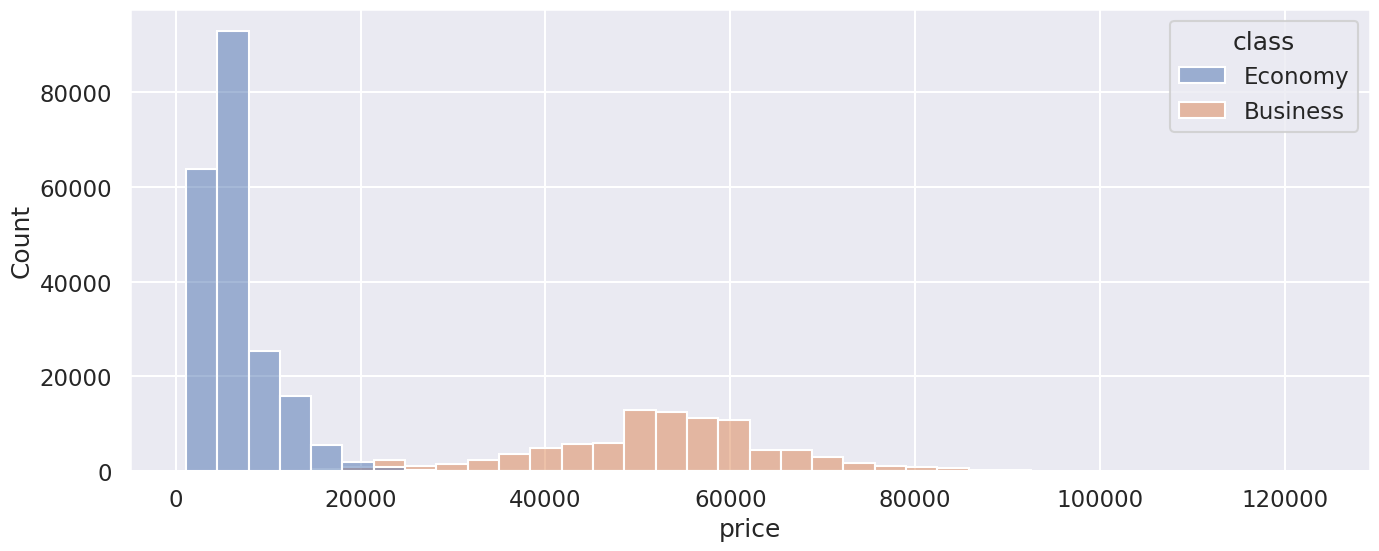

In [124]:
import warnings
warnings.filterwarnings("ignore")

# はっきりとした違いがある
plt.figure(figsize=(16, 6))
sns.histplot(data=df, x='price', hue='class', bins=36) # binsは多めにしてみる
plt.show()

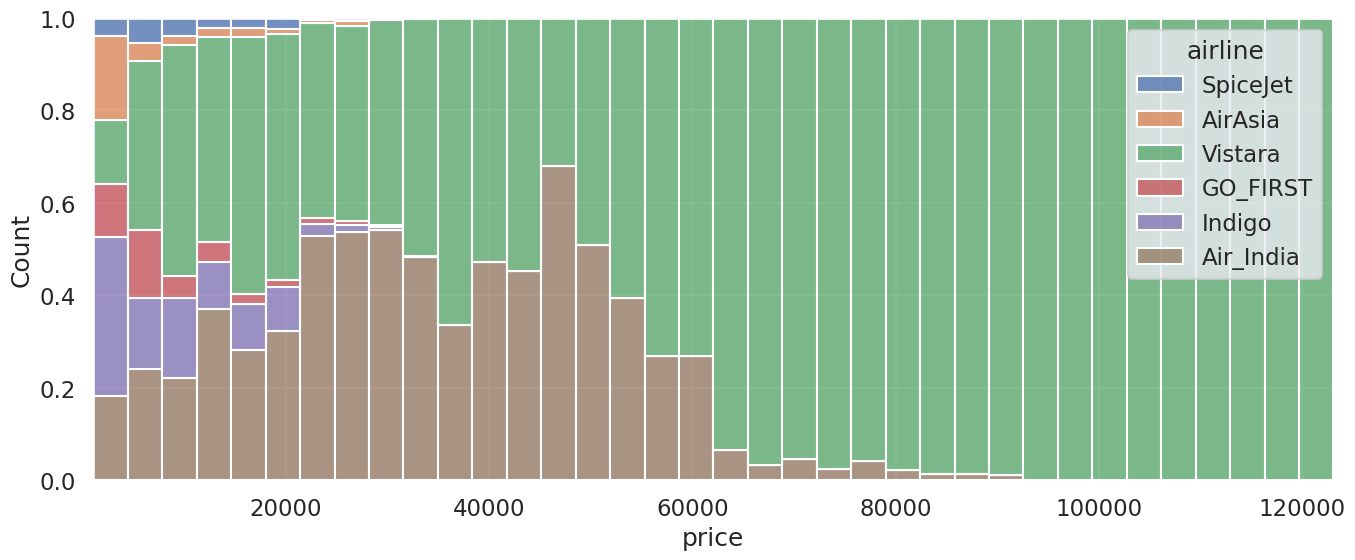

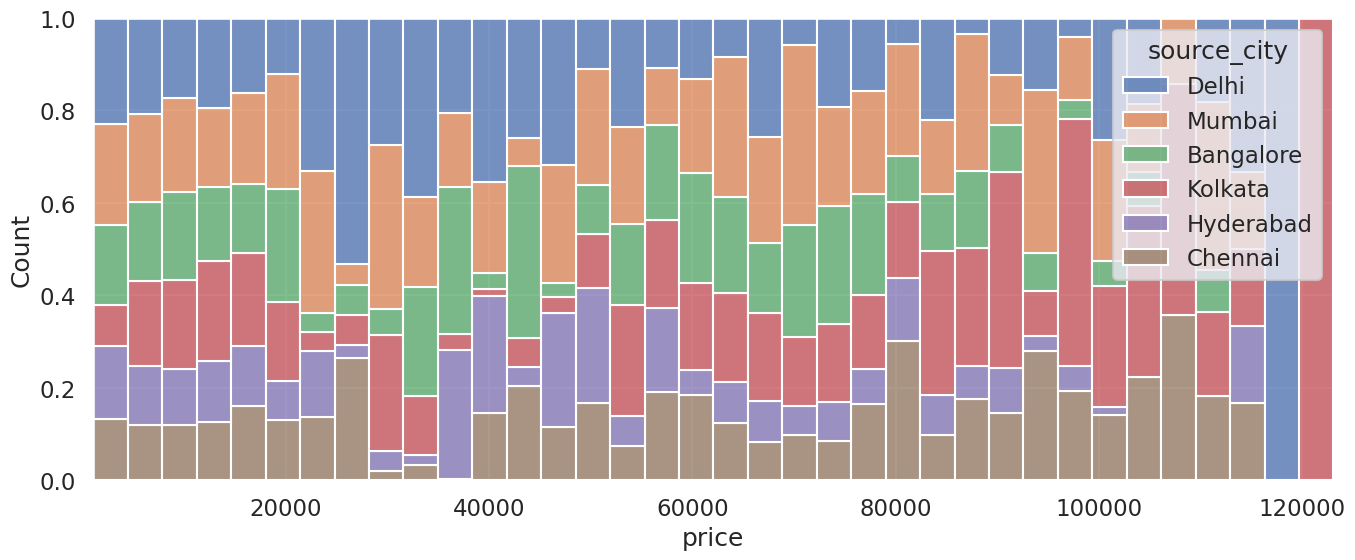

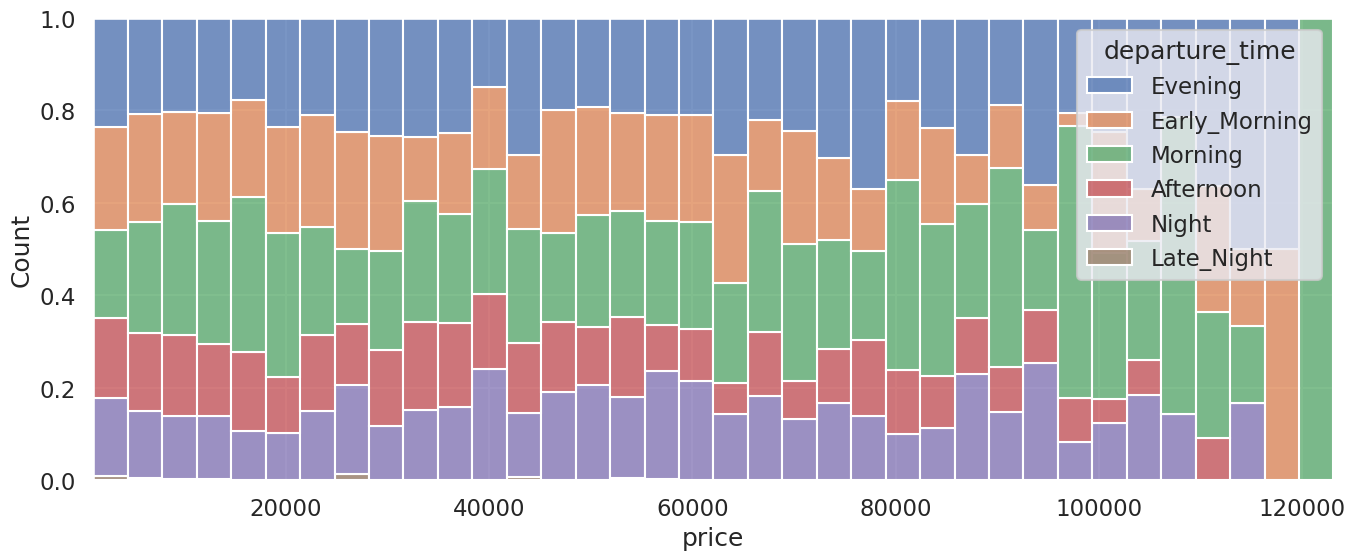

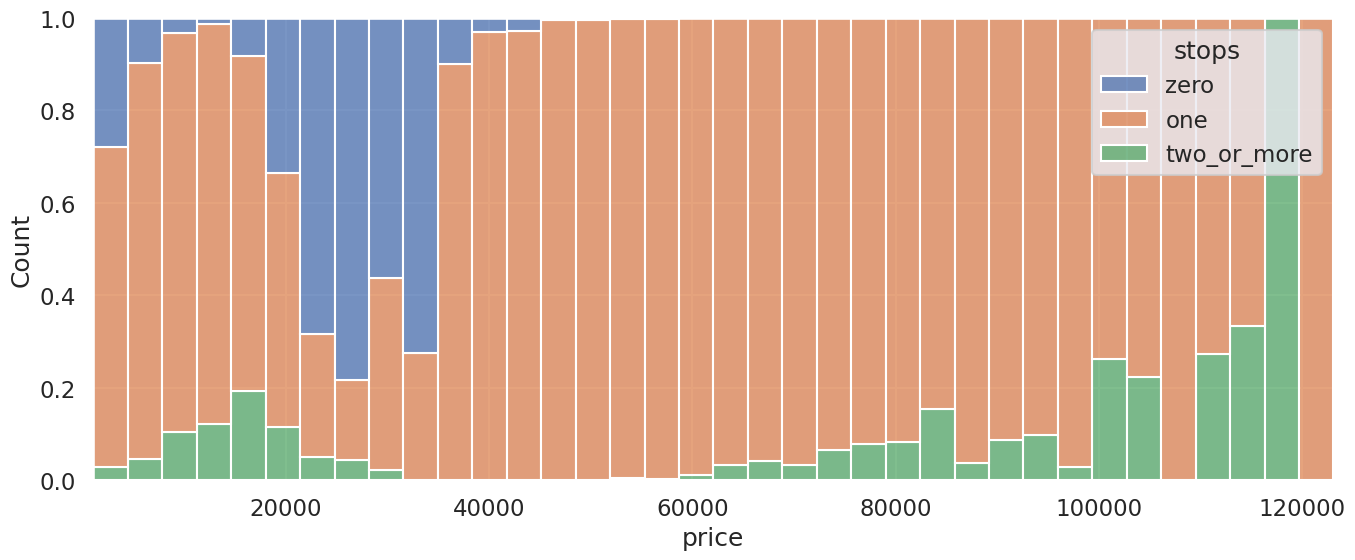

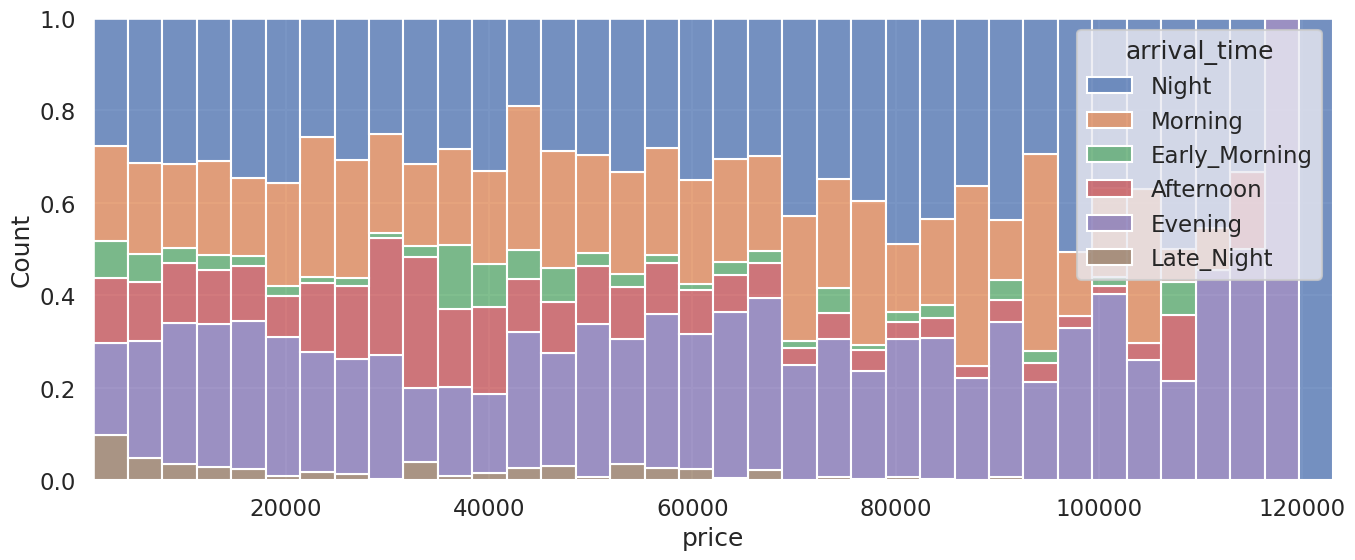

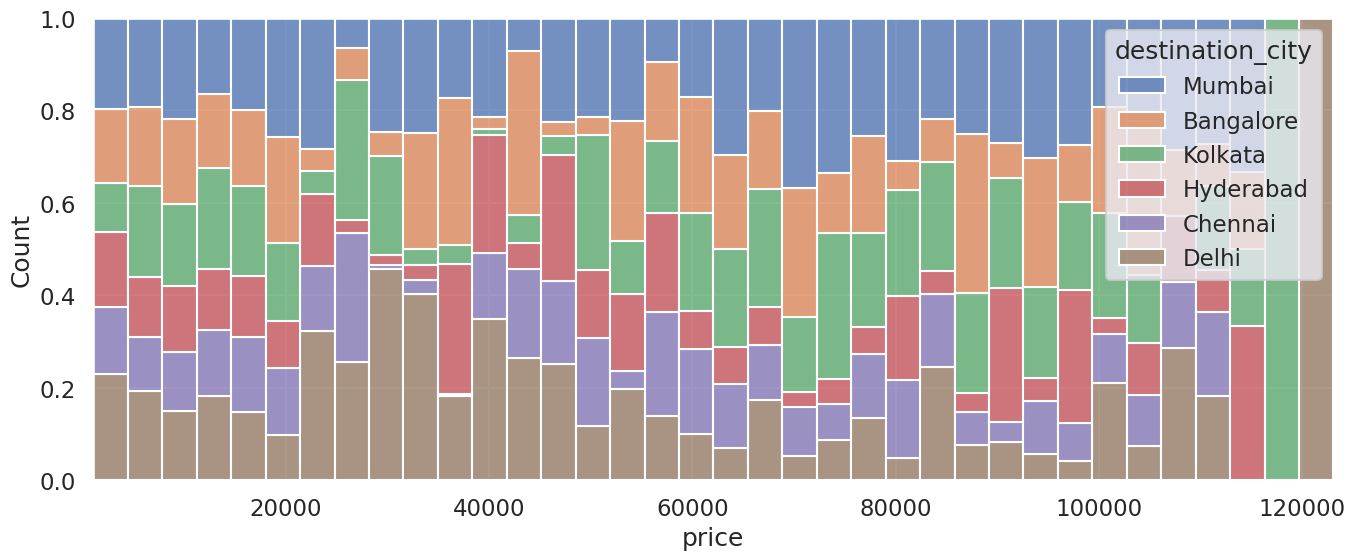

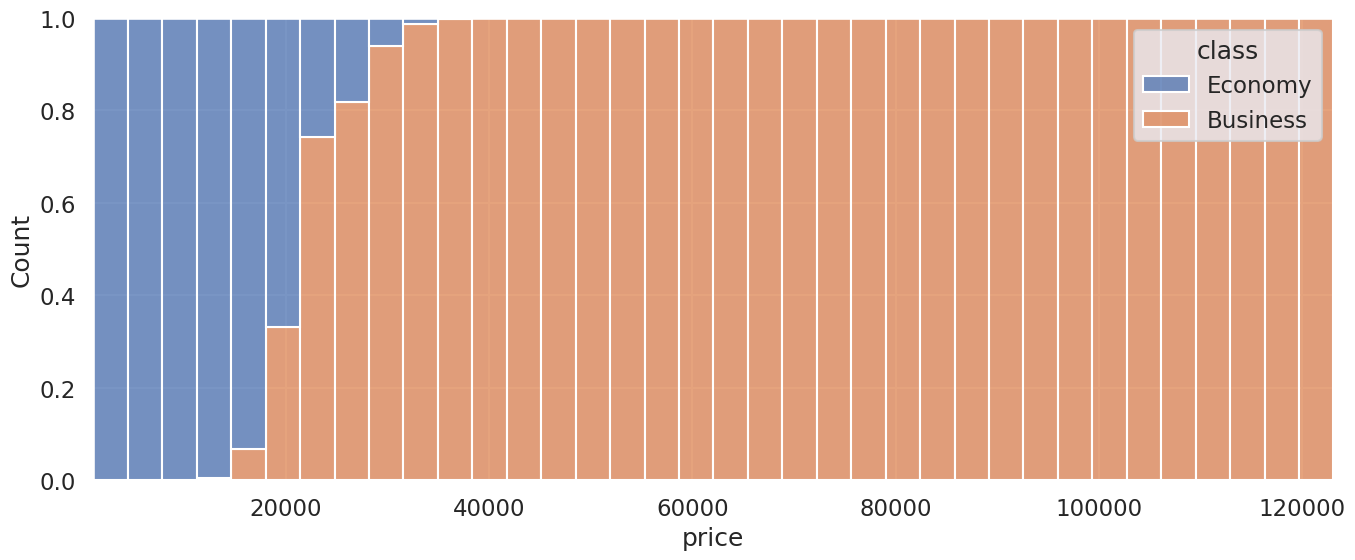

In [125]:
import warnings
warnings.filterwarnings("ignore")

# 他のカテゴリカル特徴量についても同様に確認
for feature in cat_features:
    plt.figure(figsize=(16, 6))
    sns.histplot(data=df, x='price', hue=feature, multiple='fill', bins=36) # binsは多めにしてみる
    plt.show()

**気付き**
- airlineごとに価格帯の違いがある→airlineがあるだけで価格帯の予想ができそう
- source_city(出発地): 傾向を掴みにくいが、最高価格帯は'Delhi','Kolkata'のみ
- departure_time(出発時間): 傾向は掴みにくい
- stops(乗り継ぎ): 0stop=直行便が安く、乗り継ぎアリだと低価格と高価格に分布
- arrival_time: 深夜着の便は高価格なものはなさそう
- destination_city(到着地): 傾向を掴みにくいが、最高価格帯は'Delhi','Kolkata'のみ

**Next Action**
- 残りのNumericデータも確認する

In [126]:
# numeric_featureとpriceの関係を確認
# メモ："num_features + ['price']"はnum_featuresに目的変数のpriceの特徴量を追加している
# 理由：priceとの相関を見るため
df[num_features + ['price']].corr()

# 動作確認
# df[num_features] # ['price']].corr()

,duration,days_left,price
duration,1.000000,-0.039157,0.204222
days_left,-0.039157,1.000000,-0.091949
price,0.204222,-0.091949,1.000000


**気付き**
- あまり相関関係はなさそう

**Next Action**
- 機械学習モデルを作成

In [127]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

In [129]:
# trainデータとtestデータに分割
df_y = df.pop('price') # dfからpriceを削除 (popした対象が格納されるみたい)
df_X = df # priceが削除されたdf
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=17)

In [132]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((240122, 9), (60031, 9), (240122,), (60031,))

In [133]:
# one-hotベクトル化
encoder = OneHotEncoder(drop='first') # 一列削除
# encoder = OneHotEncoder(sparse=False) # sparce行列ではなく、ndarrayが返ってくるようになる

# Hundle_Unknown(未知データの扱い): error, ignoreの二つある
# 今回はtestデータに入るデータがtrainデータにないことはほぼないのでデフォルトのerrorにする

In [139]:
# transformしたarrayをX_train_cat_arrayに格納
X_train_cat_array = encoder.fit_transform(X_train[cat_features])

# testデータも同様に。X_trainをfitさせたencoderを使う
X_test_cat_array = encoder.transform(X_test[cat_features])

X_train_cat_array[:3].toarray() # array型に変更: 1つのarrayに28個格納されている

array([[0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.]])

**メモ**　参考：https://zerofromlight.com/blogs/detail/71/
- OneHotEncoderを使って前処理を行うと、fit()メソッドにより適合されたカテゴリーのラベルを保持しているので、訓練データと同等の変換を未知データに対して行ってくれる
- 本番データで未知データをベクトル化する際に同じラベル数(ダミー変数の数)でベクトル化してくれる

In [148]:
# ベクトル化すると、特徴量分のラベルが作成される
# 今回は全部で35個作成される
# 実際に計算すると、最初の列を削除しているので、28個になっている
  # イメージ :
  # [airline1,...,airline6,source_city1,...,source_city6,...] = 35個
n = 0
print("特徴量の数(それぞれの持つ種類): ")
for feature in cat_features:
    # print(df[feature].nunique()) # 各特徴量の数を表示
    print(f'{feature} : {df[feature].nunique()}') # 各特徴量の数を表示
    n += df[feature].nunique()
print(n)
n - len(cat_features) # drop=dirstで最初の列を削除している

特徴量の数(それぞれの持つ種類): 
airline : 6
source_city : 6
departure_time : 6
stops : 3
arrival_time : 6
destination_city : 6
class : 2
35


28

この場合、それぞれの特徴量に `drop_first=True` を適用すると、以下のように**カテゴリ数 - 1 のダミー変数が残る**形になります。具体的に見てみましょう：

---

### **特徴量ごとの結果**
1. **`airline` (6種類)**  
   → 6種類のカテゴリから最初の1つを削除し、**5列のダミー変数**が作成される。

2. **`source_city` (6種類)**  
   → 同様に、最初の1つのカテゴリが削除され、**5列のダミー変数**が作成される。

3. **`departure_time` (6種類)**  
   → 最初の1つのカテゴリが削除され、**5列のダミー変数**が作成される。

4. **`stops` (3種類)**  
   → 最初の1つのカテゴリが削除され、**2列のダミー変数**が作成される。

5. **`arrival_time` (6種類)**  
   → 最初の1つのカテゴリが削除され、**5列のダミー変数**が作成される。

6. **`destination_city` (6種類)**  
   → 最初の1つのカテゴリが削除され、**5列のダミー変数**が作成される。

7. **`class` (2種類)**  
   → 最初の1つのカテゴリが削除され、**1列のダミー変数**が作成される。

---

### **最終的なダミー変数の数**
| 特徴量            | 元のカテゴリ数 | `drop_first=True`適用後の列数 |
|--------------------|----------------|-------------------------------|
| airline           | 6              | 5                             |
| source_city       | 6              | 5                             |
| departure_time    | 6              | 5                             |
| stops             | 3              | 2                             |
| arrival_time      | 6              | 5                             |
| destination_city  | 6              | 5                             |
| class             | 2              | 1                             |
| **合計**          | **35**         | **28**                        |

---

### **解釈**
- **削除された列は基準カテゴリとして機能**します。削除されたカテゴリの情報は、残りのダミー変数から推測可能なため、情報が失われることはありません。
- 例えば、`class` では「最初のカテゴリ（例: エコノミー）」が削除され、「ビジネス」を表すダミー変数が1列だけ残ります。このダミー変数が0ならエコノミー、1ならビジネスと判定できます。

---

### **注意点**
1. **カテゴリ分布が偏っている場合の影響**
   - 例えば、`airline` の6種類のカテゴリのうち、特定のカテゴリがデータの90%以上を占める場合、そのカテゴリを削除すると、重要な情報をモデルがうまく学習できない可能性があります。  
   - このような場合、削除する列を自動で選択するのではなく、慎重に選ぶ必要があります。

2. **多重共線性の解消**  
   - `drop_first=True` は多重共線性の解消に有効ですが、この方法では**相関が高い特徴量間の多重共線性**（例: `departure_time` と `arrival_time` が関連している場合）は解決できません。これを防ぐには、相関行列の確認や主成分分析（PCA）などの手法を検討すべきです。

---

### **結論**
- 上記の特徴量構造の場合、`drop_first=True` を適用すると**28列のダミー変数**が作成されます。
- 大抵のケースではこれで十分に機能しますが、カテゴリ分布の偏りや特徴量間の相関が強い場合は、追加の対策が必要になることを念頭に置いておくとよいでしょう。

何か追加で気になる点があればお知らせください！

### **特徴量についての学びメモ**
- 特徴量同士は独立した特徴を持つ方が良い(説明変数同士で相関係数が高いのはあまり良くない)
- 相関が高い説明変数があると、どちらかがわかると、もう片方が決まってしまうという状況になり、分類結果に支障はなくても情報の重要度に偏りが出る(一方が重要度高くてもう一方が低くなってしまうなど)場合があるため、最初の列を削除することが多い
- drop=firstで最初の列を削除しても、他の列から計算してその列の情報を特定できるので、削除しても情報が失われることはない。
- drop=firstでも完全ではないので、そもそも重複するような特徴量は削除するのが良い


**LLMによるdrop_first=Trueの結論**
- 大抵の場合で十分: 特に単純なカテゴリ（2カテゴリ）や均等な分布のデータでは、これだけで問題なく多重共線性を解消可能。

注意が必要なケース:
- データ分布が偏っている。
- 高相関なカテゴリが多い。
- 変数間の関連性が高い場合。

これらの場合は、手動削除、相関行列の利用、またはPCAを併用することで対応可能です。

**特徴量についての学びメモ(LLMによる修正版)**
以下に記載された学びの内容は大筋で正しいですが、若干の修正や補足を行います。

---

### **修正版: 特徴量についての学びメモ**

1. **特徴量同士は独立した特徴を持つ方が良い**  
   - 説明変数同士で相関係数が高い場合、多重共線性の問題が発生することがあります。これはモデルの安定性や解釈性に悪影響を与えるため、特徴量同士はできるだけ独立した情報を持つことが望ましいです。

2. **相関が高い説明変数の問題点**  
   - 相関が高い説明変数（特徴量）があると、片方の値がわかればもう片方が推測可能になります。このため、以下の問題が生じる可能性があります：
     - **モデル解釈への影響**: 特徴量の重要度が片方に偏り、一方が重要視されすぎ、もう片方が軽視されることがあります。  
     - **モデルの安定性への影響**: 多重共線性が強いと、回帰モデルや線形モデルの係数が不安定になりやすい。

3. **`drop_first=True`での列削除の考え方**  
   - `drop_first=True`で最初の列を削除するのは、ワンホットエンコーディングによる**多重共線性の解消**が目的です。  
   - 削除しても、他の列から計算することで基準となるカテゴリ（削除された列）の情報を特定できるため、**情報が失われることはありません**。  
   - ただし、この手法は**カテゴリ変数に限定された解決策**であり、数値変数間の相関問題には適用できません。

4. **`drop_first=True`でも完全ではない**  
   - `drop_first=True`は単純な多重共線性の解消には有効ですが、以下の点では完全ではありません：
     - **相関の高い特徴量間の問題を選別できない**: 相関が高い数値変数や、複数の関連性が強いカテゴリ変数には効果がありません。
     - **自動で削除する列の選択が最適化されない**: 最初の列を削除する仕様のため、相関が高い列を優先的に削除することはできません。

5. **重複する特徴量の削除が重要**  
   - `drop_first`などの機械的な手法に頼るだけでは不十分な場合があります。そもそも重複や相関の高い特徴量がある場合は、次のような方法で削除するのが望ましいです：
     - **相関行列を確認し、相関の高い特徴量を手動で削除する**  
     - **主成分分析（PCA）で次元削減を行い、特徴量間の冗長性を解消する**  
     - **LASSOやRidgeなどの正則化手法を利用して、自動的に重要な特徴量を選択する**

---

### **補足ポイント**
1. **相関の影響はモデルによる**  
   - 線形回帰モデルやロジスティック回帰などでは、多重共線性がモデル性能や係数の解釈性に大きな影響を与える可能性があります。  
   - 一方、決定木系のモデル（ランダムフォレストや勾配ブースティングなど）は、多重共線性の影響を受けにくい設計になっており、分類性能そのものは大きく損なわれません。ただし、**特徴量の重要度（Feature Importance）が偏る**という課題は残ります。

2. **カテゴリ変数と数値変数での扱いの違い**  
   - `drop_first`は**カテゴリ変数のワンホットエンコーディング**に特化した手法です。数値変数間の相関が問題になる場合は、別のアプローチ（例: 相関行列や次元削減）を検討する必要があります。

3. **モデル解釈の視点からの注意**  
   - 特徴量の削除がモデルの解釈性にどのように影響するかを考慮することも重要です。特に実務では、重要なビジネス要因が削除されないよう、慎重に特徴量選択を行う必要があります。

---

### **最終的な結論**
- **`drop_first=True`は基本的に有効**で、多くのケースでは十分ですが、万能ではありません。
- **特徴量選択の手法はデータやモデルに応じて柔軟に選ぶ**必要があります。特に、相関が高い変数の選別や削除は、データの特徴を理解しながら慎重に進めるべきです。

---

これで修正と補足が完了しました。他に不明点や追加の質問があれば、教えてください！

**数値変数も追加する**

In [151]:
X_train_num_array = X_train[num_features].values # ndarrayなのでvaluesで取得
X_test_num_array = X_test[num_features].values
X_train_num_array[:3]

array([[ 7.33, 22.  ],
       [23.  ,  4.  ],
       [23.33, 27.  ]])

In [155]:
# カテゴリカル変数とニューメリック変数を列方向に結合(横に追加する)
X_train = np.concatenate([X_train_cat_array.toarray(), X_train_num_array], axis=1)
X_test = np.concatenate([X_test_cat_array.toarray(), X_test_num_array], axis=1)
X_train[:3]

array([[ 0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  1.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         1.  ,  7.33, 22.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,
         1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,
         0.  , 23.  ,  4.  ],
       [ 1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         1.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,
         0.  , 23.33, 27.  ]])

**28+2=30列の特徴量が作成された**
- 前処理完了

**Next Action**
- モデルの作成

In [164]:
rf_model = RandomForestRegressor(random_state=17)

In [165]:
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=17)

In [166]:
pred = rf_model.predict(X_test)

In [48]:
# 評価
mae = np.round(mean_absolute_error(y_test, pred), 4)
mse = np.round(mean_squared_error(y_test, pred), 4)
mape = np.round(mean_absolute_percentage_error(y_test, pred), 4)
print(mae, mse, mape)

1085.5857 7645572.3501 0.0716


[mape] パーセントで見ると、7%くらいの誤差

In [49]:
#予測結果をSubmit用のcsvとして作成
submit = pd.read_csv('/kaggle/input/submit-file/submit.csv') # , index_col=0))
submit['price'] = list(map(int, pred)) # y_pred_submit))
submit.to_csv('submit_flight.csv', index=False)